In [1]:
#!pip install sentinelhub
#!pip install geopandas
#!sudo pip3 install eo-learn

In [124]:
from eolearn.core import EOTask, EOPatch, LinearWorkflow, Dependency, FeatureType
from eolearn.core import OverwritePermission
# We'll use Sentinel-2 imagery (Level-1C) provided through Sentinel Hub
# If you don't know what `Level 1C` means, don't worry. It doesn't matter.
from eolearn.io import S2L1CWCSInput, SentinelHubWCSInput, SentinelHubOGCInput
from eolearn.core import LoadFromDisk, SaveToDisk


# The golden standard: numpy and matplotlib
import numpy as np

# import matplotlib TODO
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# For manipulating geo-spatial vector dataset (polygons of nominal water extent)
import geopandas as gpd

# Loading polygon of nominal water extent
import shapely.wkt
from shapely.geometry import Polygon

# sentinelhub-py package
from sentinelhub import BBox, CRS, DataSource

import geopandas as gpd

from math import pi, log, tan, exp, atan, log2, floor
import urllib.request
from PIL import Image
import io

In [125]:
ZOOM0_SIZE = 512

#codes for obtaining base map png

def g2p(lat, lon, zoom):
    return (
        ZOOM0_SIZE * (2 ** zoom) * (1 + lon / 180) / 2,
        ZOOM0_SIZE / (2 * pi) * (2 ** zoom) * (pi - log(tan(pi / 4 * (1 + lat / 90))))
    )

def p2g(x, y, zoom):
    return (
        (atan(exp(pi - y / ZOOM0_SIZE * (2 * pi) / (2 ** zoom))) / pi * 4 - 1) * 90,
        (x / ZOOM0_SIZE * 2 / (2 ** zoom) - 1) * 180,
    )

def ax2mb(left, right, bottom, top):
    return (left, bottom, right, top)

def mb2ax(left, bottom, right, top):
    return (left, right, bottom, top)
def get_map_by_bbox(bbox):
    token = "pk.eyJ1IjoiZ2swMyIsImEiOiJhMzEwZTIyYWRhZWFjNWE5MTg0MzVkOGU5MjUyNzkxMiJ9.MKrbn4sDFM-oNMc9QupIKg"

    (left, bottom, right, top) = bbox

    assert (-90 <= bottom < top <= 90)
    assert (-180 <= left < right <= 180)

    (w, h) = (1024, 1024)

    (lat, lon) = ((top + bottom) / 2, (left + right) / 2)

    snap_to_dyadic = (lambda a, b: (lambda x, scale=(2 ** floor(log2(abs(b - a) / 4))): (round(x / scale) * scale)))

    lat = snap_to_dyadic(bottom, top)(lat)
    lon = snap_to_dyadic(left, right)(lon)

    assert ((bottom < lat < top) and (left < lon < right)), "Reference point not inside the region of interest"

    for zoom in range(16, 0, -1):
        (x0, y0) = g2p(lat, lon, zoom)

        (TOP, LEFT) = p2g(x0 - w / 2, y0 - h / 2, zoom)
        (BOTTOM, RIGHT) = p2g(x0 + w / 2, y0 + h / 2, zoom)

        if (LEFT <= left < right <= RIGHT):
            if (BOTTOM <= bottom < top <= TOP):
                break

    params = {
        'style': "streets-v10",
        'lat': lat,
        'lon': lon,
        'token': token,
        'zoom': zoom,
        'w': w,
        'h': h,
        'retina': "@2x",
    }

    url_template = "https://api.mapbox.com/styles/v1/mapbox/{style}/static/{lon},{lat},{zoom}/{w}x{h}{retina}?access_token={token}&attribution=false&logo=false"
    url = url_template.format(**params)

    with urllib.request.urlopen(url) as response:
        j = Image.open(io.BytesIO(response.read()))

    (W, H) = j.size
    assert ((W, H) in [(w, h), (2 * w, 2 * h)])

    i = j.crop((
        round(W * (left - LEFT) / (RIGHT - LEFT)),
        round(H * (top - TOP) / (BOTTOM - TOP)),
        round(W * (right - LEFT) / (RIGHT - LEFT)),
        round(H * (bottom - TOP) / (BOTTOM - TOP)),
    ))

    return i

In [2]:
class S5PL2CWCSInput(SentinelHubWCSInput):
    """
    Task for creating EOPatches and filling them with Sentinel-5P L2 data using Sentinel Hub's WCS request.
    """
    def __init__(self, layer, **kwargs):
        super().__init__(layer=layer, data_source=DataSource.SENTINEL5P, **kwargs)

In [170]:
input_task = S2L1CWCSInput('1_TRUE_COLOR', resx='50m', resy='50m', maxcc=.5,instance_id="f9ffdffa-be54-4758-a111-be29f5331746")
#input_task = S2L1CWCSInput('1_TRUE_COLOR', resx='50m', resy='50m', maxcc=1, instance_id="f9ffdffa-be54-4758-a111-be29f5331746")
# o3 = S5PL2CWCSInput('O3', resx='1000m', resy='1000m', maxcc=1,instance_id="73f6b3e5-903b-4689-a1d1-7fbb6918d811")
# so2 = S5PL2CWCSInput('SO2', resx='1000m', resy='1000m', maxcc=0.5,instance_id="73f6b3e5-903b-4689-a1d1-7fbb6918d811")
# ch4 = S5PL2CWCSInput('CH4', resx='1000m', resy='1000m', maxcc=0.5,instance_id="73f6b3e5-903b-4689-a1d1-7fbb6918d811")
# no2 = S5PL2CWCSInput('NO2', resx='1000m', resy='1000m', maxcc=0.5,instance_id="73f6b3e5-903b-4689-a1d1-7fbb6918d811")
# hcho = S5PL2CWCSInput('HCHO', resx='1000m', resy='1000m', maxcc=0.5,instance_id="73f6b3e5-903b-4689-a1d1-7fbb6918d811")
# co = S5PL2CWCSInput('CO', resx='1000m', resy='1000m', maxcc=0.5,instance_id="73f6b3e5-903b-4689-a1d1-7fbb6918d811")
# aero = S5PL2CWCSInput('AER_AI_354_388', resx='1000m', resy='1000m', maxcc=0.5,instance_id="73f6b3e5-903b-4689-a1d1-7fbb6918d811")

In [171]:
time_interval = ['2019-9-20','2019-11-10']

In [172]:
#workflow = LinearWorkflow(o3,so2,ch4,no2,hcho,co,aero)
workflow = LinearWorkflow(input_task)

In [173]:
chennai = gpd.read_file("https://raw.githubusercontent.com/gok03/eo-learn-5p-support/master/kolkata.geojson")
dam_nominal = chennai.geometry[0]
inflate_bbox = 0.1
minx, miny, maxx, maxy = dam_nominal.bounds

delx = maxx - minx
dely = maxy - miny
minx = minx - delx * inflate_bbox
maxx = maxx + delx * inflate_bbox
miny = miny - dely * inflate_bbox
maxy = maxy + dely * inflate_bbox

dam_bbox = BBox([minx, miny, maxx, maxy], crs=CRS.WGS84)

In [ ]:
result = workflow.execute({input_task: {'bbox': dam_bbox, 'time_interval': time_interval}})

In [82]:
result

WorkflowResults(
  Dependency(S2L1CWCSInput):
    EOPatch(
      data: {
        1_TRUE_COLOR: numpy.ndarray(shape=(27, 1279, 1192, 3), dtype=float32)
      }
      mask: {
        IS_DATA: numpy.ndarray(shape=(27, 1279, 1192, 1), dtype=bool)
      }
      scalar: {}
      label: {}
      vector: {}
      data_timeless: {}
      mask_timeless: {}
      scalar_timeless: {}
      label_timeless: {}
      vector_timeless: {}
      meta_info: {
        maxcc: 0.5
        service_type: 'wcs'
        size_x: '50m'
        size_y: '50m'
        time_difference: datetime.timedelta(-1, 86399)
        time_interval: ['2019-9-20', '2019-11-10']
      }
      bbox: BBox(((76.78790245210016, 28.3563277627001), (77.39834002690006, 28.931420158300075)), crs=EPSG:4326)
      timestamp: [datetime.datetime(2019, 9, 22, 5, 40, 51), ..., datetime.datetime(2019, 11, 6, 5, 41, 9)], length=27
    )
)

In [83]:
patch = list(result.values())[-1]

In [85]:
patch.save('patches-kolkata-map', overwrite_permission=OverwritePermission.OVERWRITE_FEATURES)

In [160]:
patch_map = EOPatch.load("patches-chennai-map")

In [158]:
patch_data = EOPatch.load("patches-chennai-data")

In [161]:
patch_map

EOPatch(
  data: {
    1_TRUE_COLOR: numpy.ndarray(shape=(12, 1023, 501, 3), dtype=float32)
  }
  mask: {
    IS_DATA: numpy.ndarray(shape=(12, 1023, 501, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.5
    service_type: 'wcs'
    size_x: '50m'
    size_y: '50m'
    time_difference: datetime.timedelta(-1, 86399)
    time_interval: ['2019-9-20', '2019-11-10']
  }
  bbox: BBox(((80.12091643, 12.813659009999999), (80.35216927, 13.27347609)), crs=EPSG:4326)
  timestamp: [datetime.datetime(2019, 9, 23, 5, 15, 12), ..., datetime.datetime(2019, 11, 7, 5, 15, 18)], length=12
)

In [159]:
patch_data

EOPatch(
  data: {
    AER_AI_354_388: numpy.ndarray(shape=(50, 51, 25, 1), dtype=float32)
    CH4: numpy.ndarray(shape=(50, 51, 25, 1), dtype=float32)
    CO: numpy.ndarray(shape=(50, 51, 25, 1), dtype=float32)
    HCHO: numpy.ndarray(shape=(50, 51, 25, 1), dtype=float32)
    NO2: numpy.ndarray(shape=(50, 51, 25, 1), dtype=float32)
    O3: numpy.ndarray(shape=(50, 51, 25, 1), dtype=float32)
    SO2: numpy.ndarray(shape=(50, 51, 25, 1), dtype=float32)
  }
  mask: {
    IS_DATA: numpy.ndarray(shape=(50, 51, 25, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 1
    service_type: 'wcs'
    size_x: '1000m'
    size_y: '1000m'
    time_difference: datetime.timedelta(-1, 86399)
    time_interval: ['2019-10-20', '2019-11-10']
  }
  bbox: BBox(((80.12091643, 12.813659009999999), (80.35216927, 13.27347609)), crs=EPSG:4326)
  timestamp: [datetime.datetime(2

In [167]:
def plot_rgb_w_water(patch_map,patch_data, idx):
    ratio = np.abs(patch_data.bbox.max_x - patch_data.bbox.min_x) / np.abs(patch_data.bbox.max_y - patch_data.bbox.min_y)
    fig, ax = plt.subplots(figsize=(ratio * 10, 10))
    
    ax.imshow(patch_map.data['1_TRUE_COLOR'][-9])
    ax.imshow(np.squeeze(patch_data.data['NO2'][0]),alpha=0.5)
    ax.axis('off')

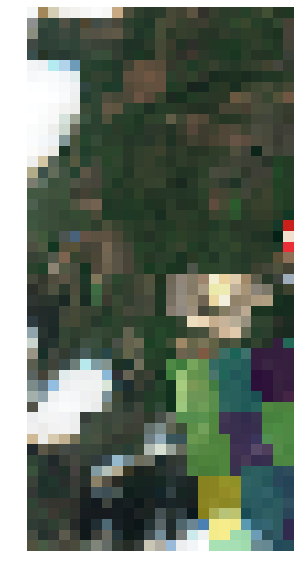

In [168]:
plot_rgb_w_water(patch_map,patch_data,-2)

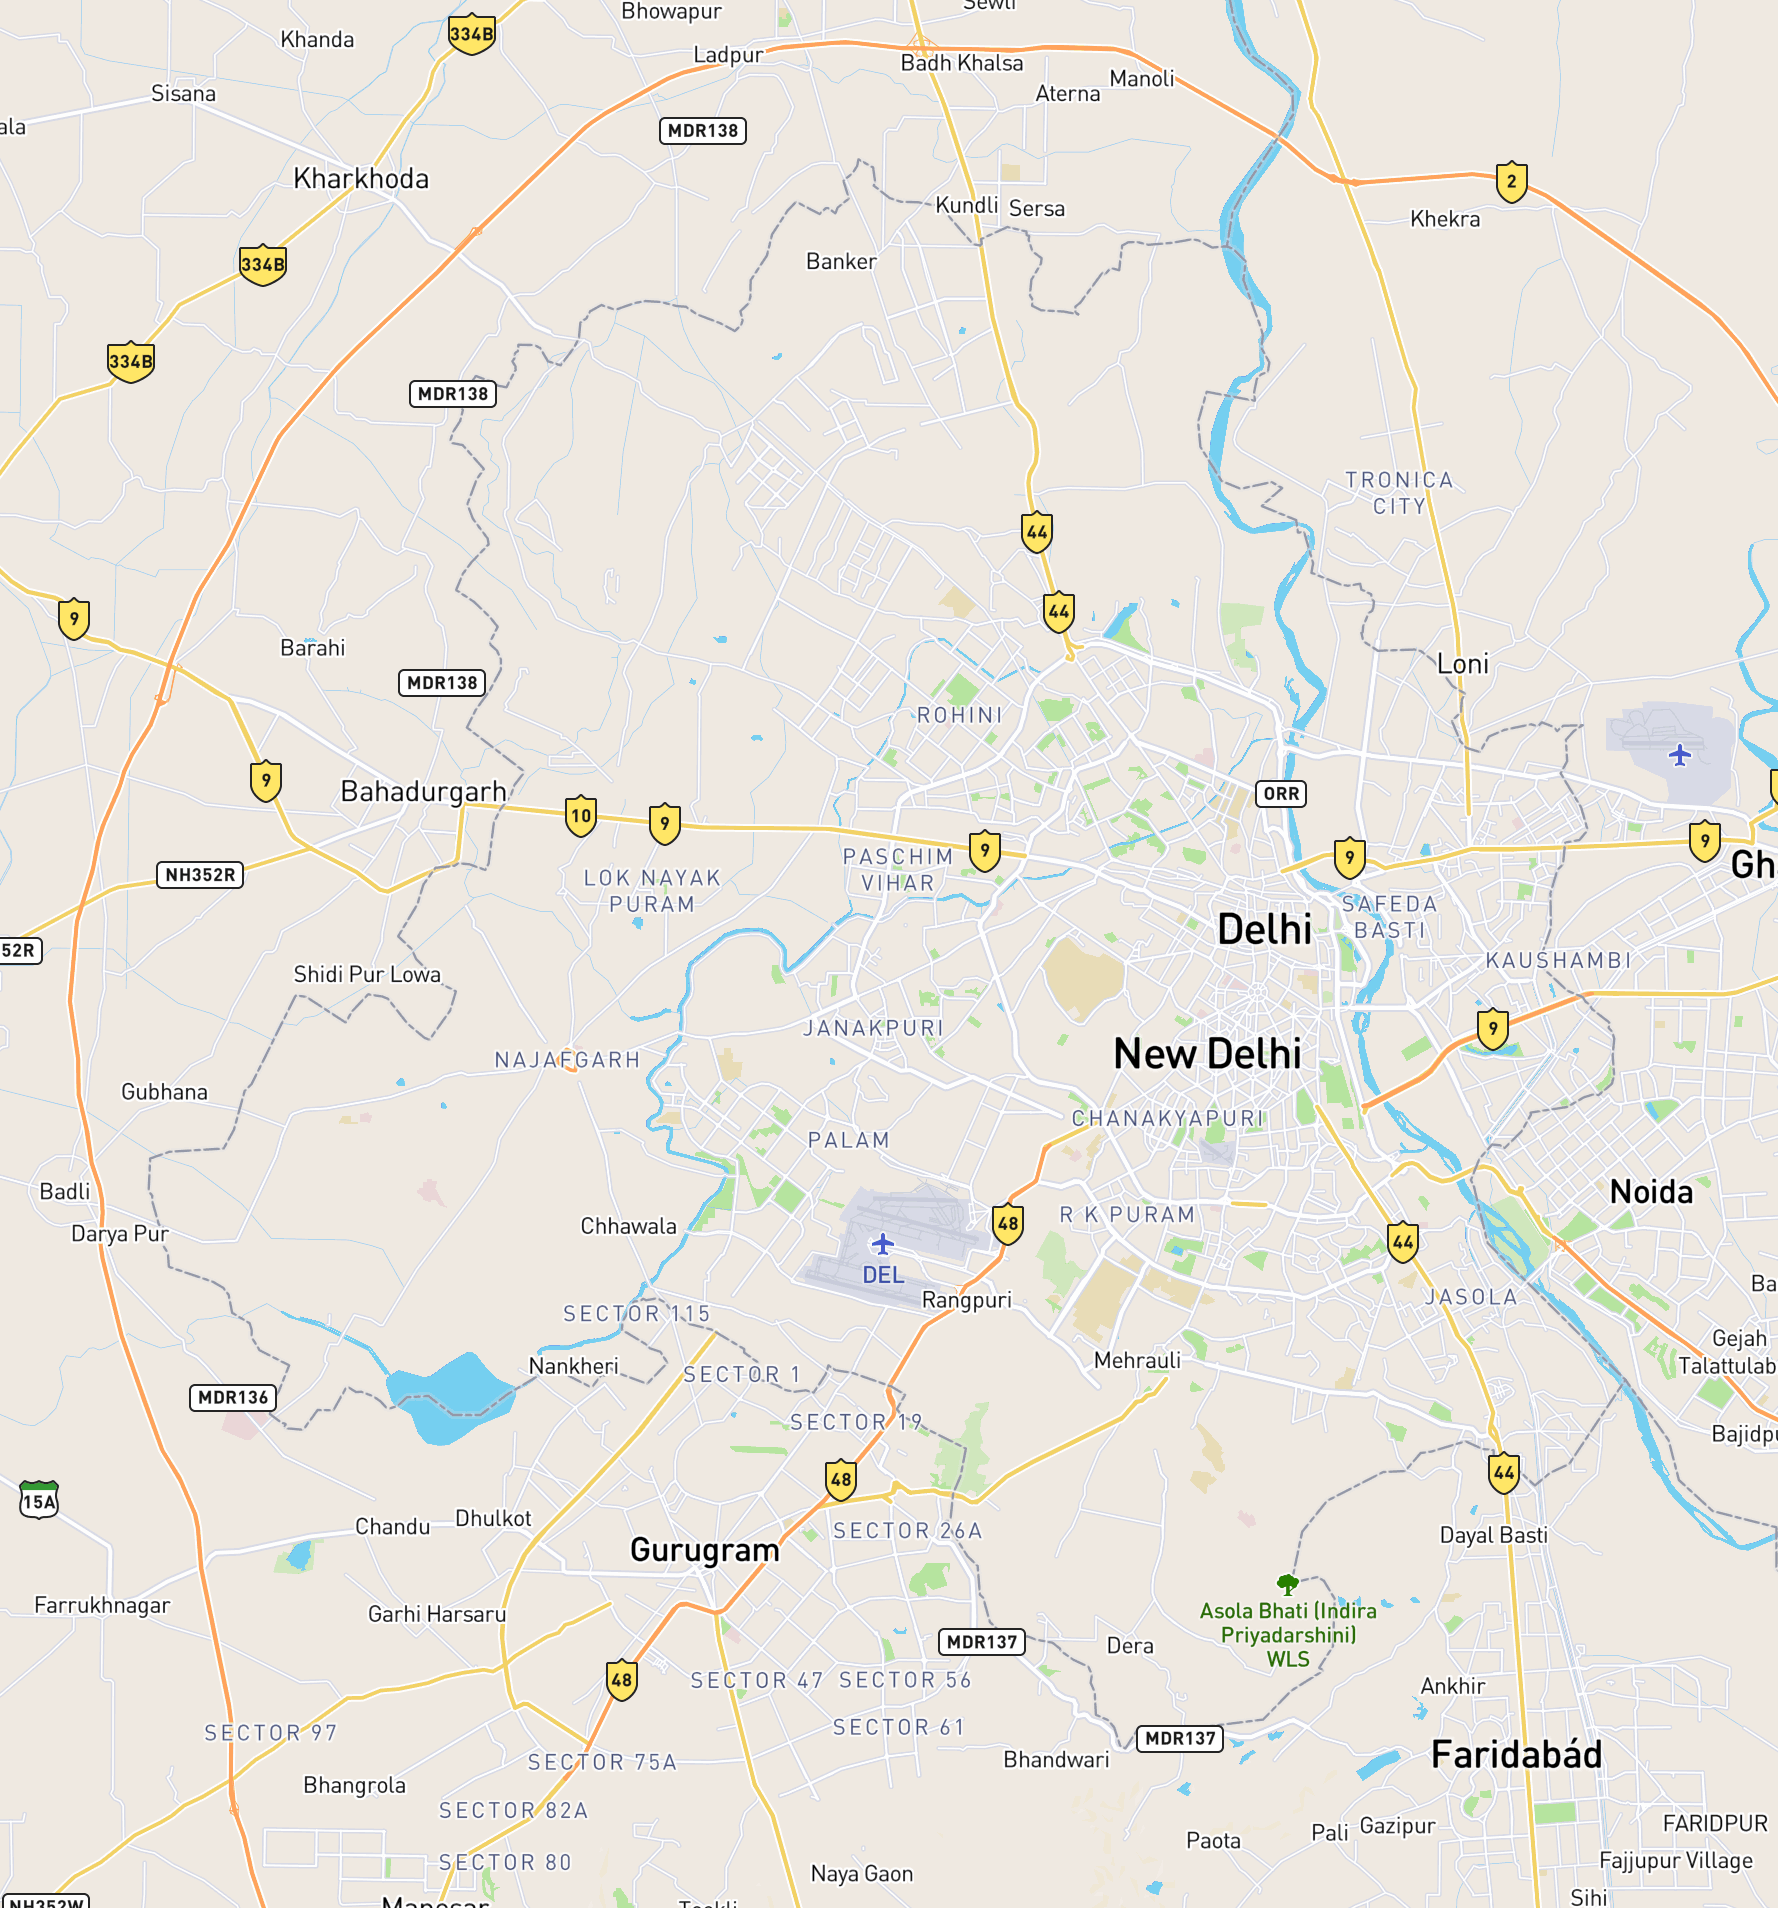